### Functions

In [1]:
import astra

def get_sinogram_slice(vol_slice, angles):
    """
    Get a sinogram from a 3D dataset slice.
    
    Parameters
    ----------
    slice : 2D numpy.ndarray
        Slice
        
    Returns
    -------
    numpy.ndarray
        2D sinogram.
        
    """
    vol_geom = astra.create_vol_geom(vol_slice.shape[1], vol_slice.shape[0])
    proj_geom = astra.create_proj_geom('parallel', 1.0, vol_slice.shape[1], angles)

    projector_id = astra.create_projector('cuda', proj_geom, vol_geom)
    _, sino  = astra.create_sino(vol_slice, projector_id)

    return sino

### Loading data 

In [2]:
import h5py
import numpy as np
import napari

def find_datasets_with_dim_3(file, group=None, path="", results=None):
    """
    Find all datasets with 3 dimensions in a HDF5 file.       
    """
    if results is None:
        results = []

    if group is None:
        group = file

    for key in group:
        item = group[key]
        current_path = f"{path}/{key}"
        if isinstance(item, h5py.Group):
            find_datasets_with_dim_3(
                file, group=item, path=current_path, results=results
            )
        elif isinstance(item, h5py.Dataset):
            if len(item.shape) == 3:
                results.append(
                    (current_path, item.shape)
                ) 
    return results

projs_path = r"D:\SOLEIL0125\025_mdb13_nocell_nocell_2d\025_mdb13_nocell_nocell_2d\025_mdb13_nocell_nocell_2d.nxs"
dark_path = r"D:\SOLEIL0125\025_mdb13_nocell_nocell_2d\025_mdb13_nocell_nocell_2d\post_dark.nxs"
flat_paths = r"D:\SOLEIL0125\025_mdb13_nocell_nocell_2d\025_mdb13_nocell_nocell_2d\post_ref.nxs"

with h5py.File(projs_path, 'r') as file:
    projs_key = find_datasets_with_dim_3(file)[0][0]
    projs = np.array(file[projs_key])[:, 150:800]
print("Projections shape:", projs.shape)

with h5py.File(dark_path, 'r') as file:
    dark_key = find_datasets_with_dim_3(file)[0][0]
    dark = np.mean(np.array(file[dark_key]), axis=0)[150:800]
print("Dark shape:", dark.shape)

flat = []
with h5py.File(flat_paths, 'r') as file:
    flat_key = find_datasets_with_dim_3(file)[0][0]
    flat = np.mean(np.array(file[flat_key]), axis=0)[150:800]
print("Flat shape:", flat.shape)

Projections shape: (2850, 650, 1472)
Dark shape: (650, 1472)
Flat shape: (650, 1472)


In [3]:
### Get Center of Rotation from csv file


import pandas as pd
import os

csv_path = r"C:\Users\clement.capdeville\Documents\GitHub\SOLEIL25\part_info.csv"
part_info = pd.read_csv(csv_path)
filtered_info = part_info.loc[part_info["Path"] == os.path.basename(projs_path).split(".")[0]]
CoR = filtered_info["CoR"].values[0] if not filtered_info.empty else None
angle_padding = filtered_info["Angle"].values[0] if not filtered_info.empty else None

print("CoR:", CoR)
print("Angle padding:", angle_padding)

CoR: 287.5329942270546
Angle padding: 0.1264044943820224


### Preprocessing

In [4]:
projs = (projs - dark) / (flat - dark)

In [5]:
import napari

view = napari.Viewer()
view.add_image(projs, name="Projections", colormap="gray", blending="additive")

napari.manifest -> 'multipaganinproject' could not be imported: The name field in the manifest ('multipaganin-plugin') must match the package name ('multipaganinproject')


<Image layer 'Projections' at 0x204ffd0fa70>

### Raw Projections

In [5]:
import numpy as np
from tqdm import tqdm

from src.reco_plugin.processing.reconstruction import create_angles, reconstruct_from_sinogram_slice, create_disk_mask
from src.reco_plugin.processing.sinogram import create_sinogram

sinogram = create_sinogram(projs, int(2*CoR))
angles = create_angles(sinogram, end=np.pi)
raw_reconstruction = np.zeros((sinogram.shape[0], sinogram.shape[2], sinogram.shape[2]), dtype=np.float32)
mask = create_disk_mask(sinogram)

for i in tqdm(range(sinogram.shape[0]), desc="Reconstructing"):
    raw_reconstruction[i] = reconstruct_from_sinogram_slice(sinogram[i], angles) * mask

Reconstructing: 100%|██████████| 650/650 [01:51<00:00,  5.82it/s]


In [6]:
import napari

viewer = napari.Viewer()
viewer.add_image(raw_reconstruction, name="Reconstruction", colormap="gray")

napari.manifest -> 'multipaganinproject' could not be imported: The name field in the manifest ('multipaganin-plugin') must match the package name ('multipaganinproject')


<Image layer 'Reconstruction' at 0x1b7738d0ef0>

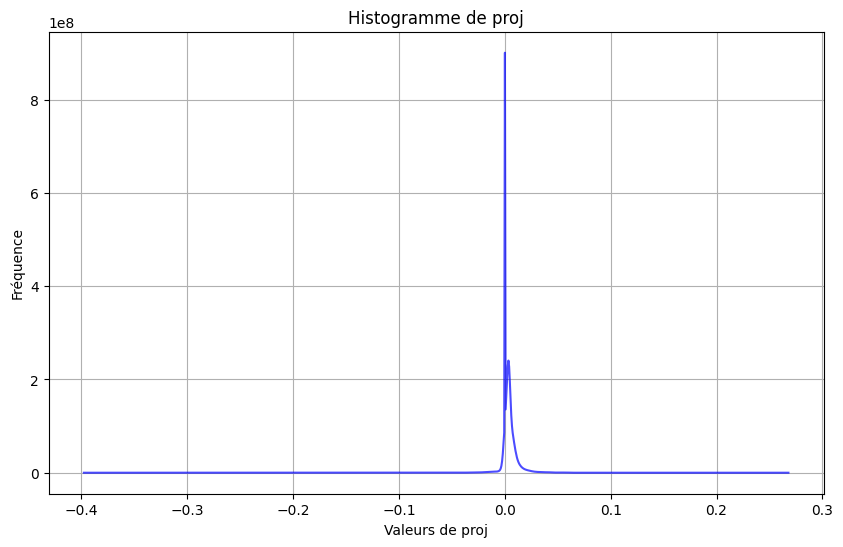

In [8]:

import matplotlib.pyplot as plt

hist, bin_edges = np.histogram(raw_reconstruction, bins=1000)  # Convert proj to NumPy array
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, hist, color='blue', alpha=0.7)
plt.title('Histogramme de proj')
plt.xlabel('Valeurs de proj')
plt.ylabel('Fréquence')
plt.grid()
plt.show()

### 1rst Paganin : Émail

In [9]:
from src.reco_plugin.processing.phase import paganin_filter

energy = 40 # keV
pixel = 12e-6 # m
effective_pixel = pixel # m
distance = 1.2 # m
db = 100

pagain_proj = paganin_filter(projs, energy, pixel, effective_pixel, distance, db)['paganin']


Processing Paganin: 100%|██████████| 2850/2850 [00:57<00:00, 49.54it/s]


In [10]:
import napari

viewer = napari.Viewer()
viewer.add_image(pagain_proj, name="Pagani Projection", colormap="gray")

<Image layer 'Pagani Projection' at 0x2086ce413a0>

In [15]:
import numpy as np
import cupy as cp
from tqdm import tqdm

from src.reco_plugin.processing.reconstruction import create_angles, reconstruct_from_sinogram_slice, create_disk_mask
from src.reco_plugin.processing.sinogram import create_sinogram
from src.reco_plugin.processing.phase import unsharp_mask

coeff = 0.5
sigma = 2

sinogram = - create_sinogram(pagain_proj, int(2*CoR))
angles = create_angles(sinogram, end=np.pi)
pag_reconstruction = np.zeros((sinogram.shape[0], sinogram.shape[2], sinogram.shape[2]), dtype=np.float32)
mask = create_disk_mask(sinogram)

for i in tqdm(range(sinogram.shape[0]), desc="Reconstructing"):
    slice_ = reconstruct_from_sinogram_slice(sinogram[i], angles) * mask
    pag_reconstruction[i] = slice_

Reconstructing: 100%|██████████| 650/650 [01:50<00:00,  5.91it/s]


In [16]:
import napari

viewer = napari.Viewer()
viewer.add_image(pag_reconstruction, name="Paganin 1 Projection 350", colormap="gray")
viewer.add_image(raw_reconstruction, name="Raw Projection", colormap="gray")

<Image layer 'Raw Projection' at 0x1bafc16fa40>

In [21]:

import matplotlib.pyplot as plt

histp, bin_edgesp = np.histogram(pag_reconstruction, bins=10000)
bin_centersp = 0.5 * (bin_edgesp[:-1] + bin_edgesp[1:])

hist, bin_edges = np.histogram(raw_reconstruction, bins=10000)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])


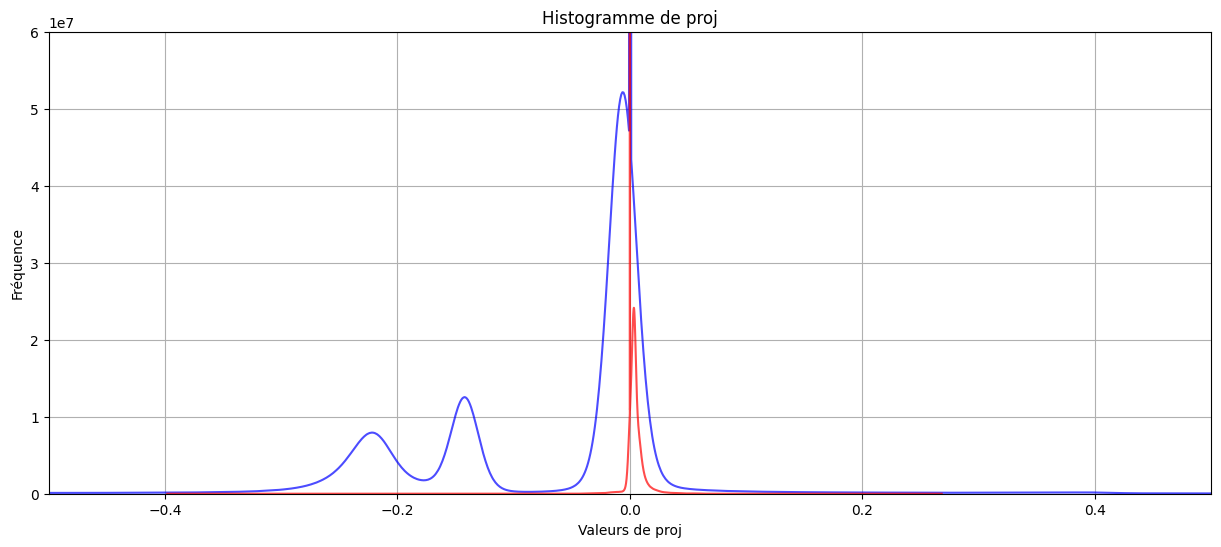

In [30]:
plt.figure(figsize=(15, 6))
plt.plot(bin_centersp, histp, color='blue', alpha=0.7)
plt.plot(bin_centers, hist, color='red', alpha=0.7)
plt.xlim(-0.5, 0.5)  # ou une autre plage en fonction des valeurs attendues
plt.ylim(0, 0.6e8)  # ou une autre plage en fonction des valeurs attendues
plt.title('Histogramme de proj')
plt.xlabel('Valeurs de proj')
plt.ylabel('Fréquence')
plt.grid()
plt.show()

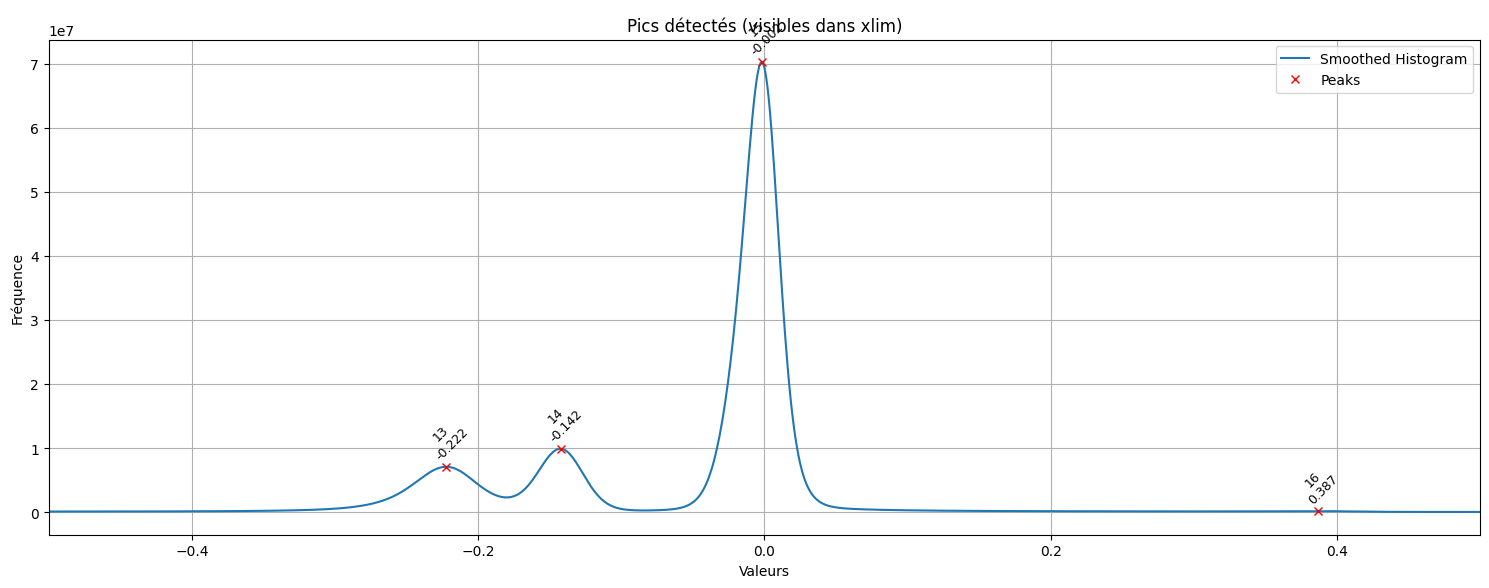

In [37]:
### Trouver le minimum entre -0.2 et -0.15 sur l'histogramme paganin

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

# Lissage
smooth_hist = gaussian_filter1d(histp, sigma=10)

# Détection des pics
peaks, _ = find_peaks(smooth_hist)

# Définir les limites de l'axe x
x_min, x_max = -0.5, 0.5

# Plot
plt.figure(figsize=(15, 6))
plt.plot(bin_centersp, smooth_hist, label='Smoothed Histogram')
plt.plot(bin_centersp[peaks], smooth_hist[peaks], "x", label="Peaks", color='red')

# Affichage conditionnel des annotations si pic est dans xlim
for i, peak in enumerate(peaks):
    x_val = bin_centersp[peak]
    y_val = smooth_hist[peak]
    if x_min <= x_val <= x_max:
        plt.text(x_val, y_val + 0.01 * smooth_hist.max(), f"{i}\n{x_val:.3f}", 
                 ha='center', va='bottom', fontsize=9, rotation=45)

# Ajustements visuels
plt.xlim(x_min, x_max)
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.title('Pics détectés (visibles dans xlim)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

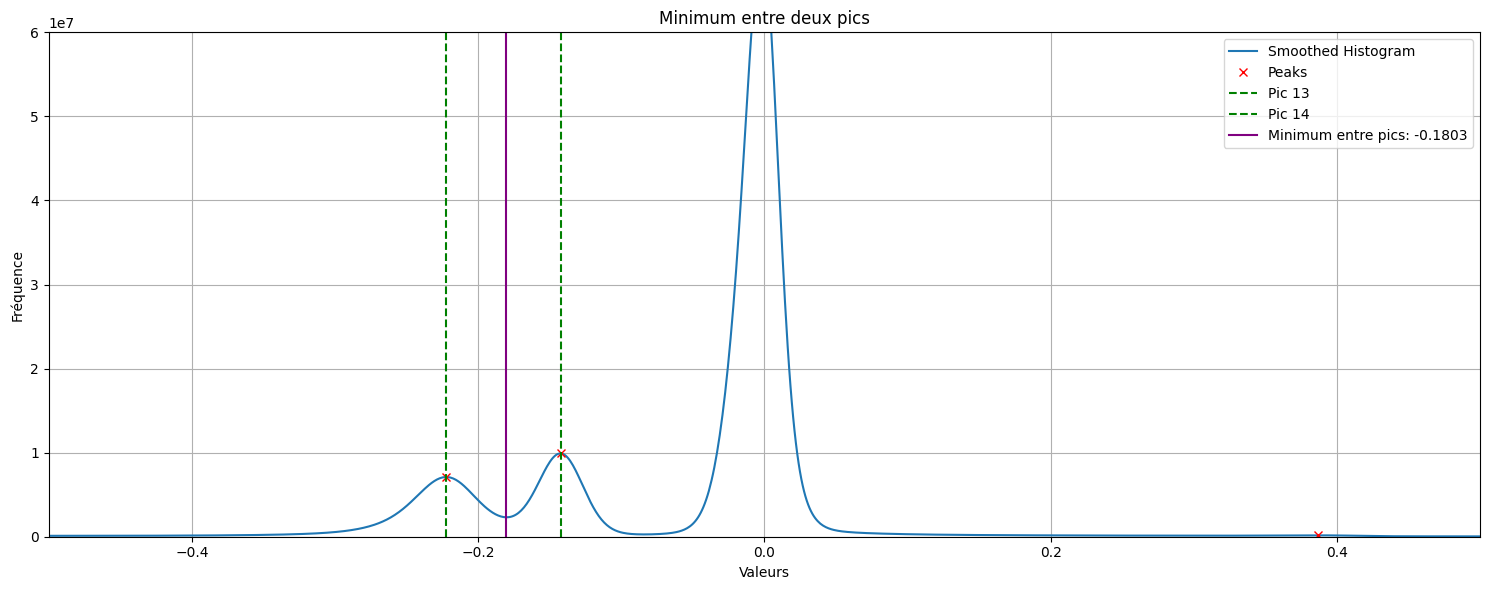

In [38]:
# Exemple : on choisit deux pics (par leurs indices dans la liste `peaks`)
i, j = 13, 14  # à ajuster selon ce que tu veux analyser

# On récupère les indices dans l'histogramme
p1_idx = peaks[i]
p2_idx = peaks[j]

# S'assurer que les indices sont dans l'ordre croissant
start, end = sorted([p1_idx, p2_idx])

# Trouver l'indice du minimum dans cette plage
min_idx_in_window = np.argmin(smooth_hist[start:end]) + start

# Valeur de seuil correspondante
threshold_value = bin_centersp[min_idx_in_window]

# Tracer pour visualiser le minimum entre les deux pics
plt.figure(figsize=(15, 6))
plt.plot(bin_centersp, smooth_hist, label='Smoothed Histogram')
plt.plot(bin_centersp[peaks], smooth_hist[peaks], "x", label="Peaks", color='red')
plt.axvline(bin_centersp[p1_idx], color='green', linestyle='--', label=f'Pic {i}')
plt.axvline(bin_centersp[p2_idx], color='green', linestyle='--', label=f'Pic {j}')
plt.axvline(threshold_value, color='purple', linestyle='-', label=f'Minimum entre pics: {threshold_value:.4f}')
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.title('Minimum entre deux pics')
plt.legend()
plt.grid()
plt.xlim(-0.5, 0.5)
plt.ylim(0, 0.6e8)
plt.tight_layout()
plt.show()


In [42]:
import cupy as cp
from tqdm import tqdm

from cupyx.scipy.ndimage import binary_dilation, percentile_filter

email = np.zeros_like(pag_reconstruction)

for i in tqdm(range(pag_reconstruction.shape[0]), desc="Reconstructing"):
    slice_ = cp.asarray(pag_reconstruction[i])
    # slice_ = percentile_filter(slice_, percentile=20, size=20)
    slice_ = cp.where(slice_ < -2 , 1, 0)
    # slice_ = binary_dilation(slice_)
    email[i] = slice_.get()

viewer = napari.Viewer()
viewer.add_image(email, name="Email", colormap="gray")
viewer.add_image(pag_reconstruction, name="Paganin 1 Projection", colormap="gray")

Reconstructing: 100%|██████████| 650/650 [00:14<00:00, 43.63it/s]


<Image layer 'Paganin 1 Projection' at 0x1bb09f649b0>

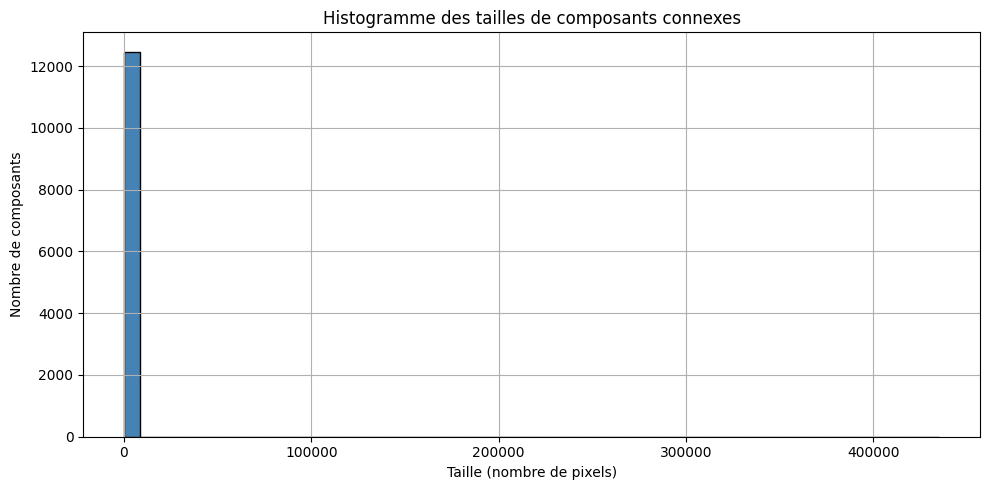

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label

# image_binaire : ton image 2D numpy (0 et 1)
# Exemple pour test : image_binaire = np.random.randint(0, 2, (100, 100))

# Étape 1 : étiquetage des composants connexes
labeled_image, num_features = label(email)

# Étape 2 : calcul des tailles de chaque composant
# On compte le nombre de pixels par label (en ignorant le label 0 qui est le fond)
sizes = np.bincount(labeled_image.ravel())[1:]


(650, 2369, 2369)
12476
Coposants les plus grands : [ 4337  4705  4087  5273  4298  5061  9783 10074  2646  2814]


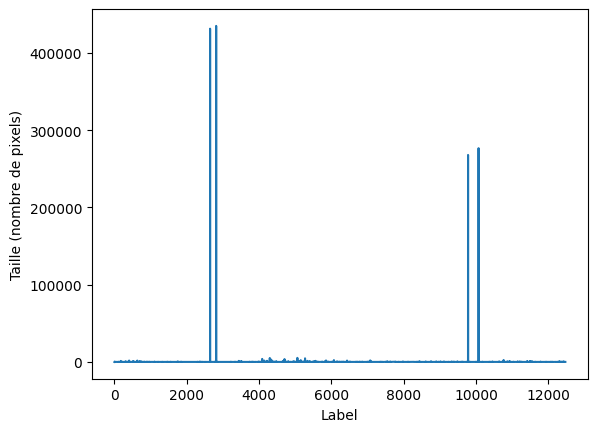

In [65]:
print(labeled_image.shape)
print(num_features)

plt.plot(sizes)
plt.xlabel('Label')
plt.ylabel('Taille (nombre de pixels)')

print("Coposants les plus grands :", np.argsort(sizes)[-10:])

In [72]:
# Filtrer les label supérieur à 100000

from tqdm import tqdm
from scipy.ndimage import binary_dilation

filtered_label = np.zeros_like(labeled_image)
for i in tqdm(range(1, num_features + 1)):
    if sizes[i - 1] > 100000:
        filtered_label[labeled_image == i] = 1

100%|██████████| 12476/12476 [00:23<00:00, 523.77it/s]


In [69]:
# filtrer les composants avec des tailles supérieur à 200000

viewer = napari.Viewer()
viewer.add_image(filtered_label, name="Filtered Image", colormap="gray")

<Image layer 'Filtered Image' at 0x1c144740740>

In [ ]:
final = np.zeros_like(raw_reconstruction)

viewer = napari.Viewer()
viewer.add_image(filtered_label, name="Filtered Image", colormap="gray")
filtered_label = binary_dilation(filtered_label, iterations=2)
viewer.add_image(filtered_label, name="Dilated Image", colormap="gray")

<Image layer 'Dilated Image' at 0x1d4421846b0>

In [74]:
final[filtered_label != 0] = pag_reconstruction[filtered_label != 0]

viewer = napari.Viewer()
viewer.add_image(final, name="Final Image", colormap="gray")

<Image layer 'Final Image' at 0x1d44624a870>

### Step 2

In [75]:
raw2_reconstruction = np.copy(raw_reconstruction)
raw2_reconstruction[filtered_label != 0] = 0.00015

viewer = napari.Viewer()
viewer.add_image(raw2_reconstruction, name="Reconstruction", colormap="gray")

<Image layer 'Reconstruction' at 0x1d5287556d0>

In [16]:
pag2_sino = np.zeros_like(sinogram)

for i in tqdm(range(raw2_reconstruction.shape[0]), desc="Reconstructing"):
    sino_ = get_sinogram_slice(raw2_reconstruction[i], angles)
    pag2_sino[i] = sino_

projs = np.swapaxes(pag2_sino, 0, 1)

Reconstructing: 100%|██████████| 650/650 [01:07<00:00,  9.62it/s]


In [17]:
viewer = napari.Viewer()
viewer.add_image(projs, name="Pagani 2 Projection", colormap="gray")

<Image layer 'Pagani 2 Projection' at 0x20c263f3b90>

In [18]:
from src.reco_plugin.processing.phase import paganin_filter

energy = 40 # keV
pixel = 12e-6 # m
effective_pixel = pixel # m
distance = 1.2 # m
db = 1500

pagain_proj = paganin_filter(projs, energy, pixel, effective_pixel, distance, db)['paganin']

Processing Paganin: 100%|██████████| 1425/1425 [01:21<00:00, 17.52it/s]


In [19]:
import numpy as np
import cupy as cp
from tqdm import tqdm

from src.reco_plugin.processing.reconstruction import create_angles, reconstruct_from_sinogram_slice, create_disk_mask
from src.reco_plugin.processing.sinogram import create_sinogram
from src.reco_plugin.processing.phase import unsharp_mask

coeff = 0.5
sigma = 2

sinogram = np.swapaxes(pagain_proj, 0, 1)
angles = create_angles(sinogram, end=np.pi)
mask = create_disk_mask(sinogram)

for i in tqdm(range(sinogram.shape[0]), desc="Reconstructing"):
    slice_ = reconstruct_from_sinogram_slice(sinogram[i], angles) * mask
    pag_reconstruction[i] = slice_

Reconstructing: 100%|██████████| 650/650 [03:01<00:00,  3.57it/s]


In [20]:
import napari

viewer = napari.Viewer()
viewer.add_image(pag_reconstruction, name="Paganin 2 Projection", colormap="gray")

<Image layer 'Paganin 2 Projection' at 0x208ace34b90>

In [21]:
import cupy as cp
from tqdm import tqdm

from cupyx.scipy.ndimage import binary_dilation, binary_erosion

dentine_os = np.zeros_like(pag_reconstruction)

for i in tqdm(range(pag_reconstruction.shape[0]), desc="Reconstructing"):
    slice_ = cp.asarray(pag_reconstruction[i])
    slice_ = cp.where(slice_ > 5, 1, 0)
    slice_ = binary_dilation(slice_)
    slice_ = binary_dilation(slice_)
    dentine_os[i] = slice_.get()

viewer = napari.Viewer()
viewer.add_image(dentine_os, name="Dentine/Os", colormap="gray")
viewer.add_image(pag_reconstruction, name="Paganin 1 Projection", colormap="gray")

Reconstructing: 100%|██████████| 650/650 [00:15<00:00, 41.45it/s]


<Image layer 'Paganin 1 Projection' at 0x20c3e190410>

In [22]:
final[dentine_os != 0] = pag_reconstruction[dentine_os != 0]

In [23]:
viewer = napari.Viewer()
viewer.add_image(final, name="Reconstruction", colormap="gray")

<Image layer 'Reconstruction' at 0x20e5d425700>

### Step 3

In [24]:
raw2_reconstruction[dentine_os != 0] = 0.0001

viewer = napari.Viewer()
viewer.add_image(raw2_reconstruction, name="Reconstruction", colormap="gray")

<Image layer 'Reconstruction' at 0x20e7babccb0>

In [25]:
pag2_sino = np.zeros_like(sinogram)

for i in tqdm(range(raw2_reconstruction.shape[0]), desc="Reconstructing"):
    sino_ = get_sinogram_slice(raw2_reconstruction[i], angles)
    pag2_sino[i] = sino_

projs = np.swapaxes(pag2_sino, 0, 1)

Reconstructing: 100%|██████████| 650/650 [01:07<00:00,  9.67it/s]


In [26]:
viewer = napari.Viewer()
viewer.add_image(projs, name="Pagani 2 Projection", colormap="gray")

<Image layer 'Pagani 2 Projection' at 0x20e8e544d10>

In [27]:
from src.reco_plugin.processing.phase import paganin_filter

energy = 40 # keV
pixel = 12e-6 # m
effective_pixel = pixel # m
distance = 1.2 # m
db = 1500

pagain2_proj = paganin_filter(projs, energy, pixel, effective_pixel, distance, db)['paganin']

Processing Paganin: 100%|██████████| 1425/1425 [01:00<00:00, 23.53it/s]


In [28]:
import numpy as np
import cupy as cp
from tqdm import tqdm

from src.reco_plugin.processing.reconstruction import create_angles, reconstruct_from_sinogram_slice, create_disk_mask
from src.reco_plugin.processing.sinogram import create_sinogram
from src.reco_plugin.processing.phase import unsharp_mask

coeff = 0.5
sigma = 2

sinogram = np.swapaxes(pagain2_proj, 0, 1)
angles = create_angles(sinogram, end=np.pi)
mask = create_disk_mask(sinogram)

for i in tqdm(range(sinogram.shape[0]), desc="Reconstructing"):
    slice_ = reconstruct_from_sinogram_slice(sinogram[i], angles) * mask
    pag_reconstruction[i] = slice_

Reconstructing: 100%|██████████| 650/650 [03:30<00:00,  3.08it/s]


In [29]:
import napari

viewer = napari.Viewer()
viewer.add_image(pag_reconstruction, name="Paganin 2 Projection", colormap="gray")

<Image layer 'Paganin 2 Projection' at 0x20481c332f0>

In [30]:
# pag_reconstruction[final != 0] = final[final != 0]
test = np.copy(pag_reconstruction)
test[final != 0] = final[final != 0]

In [31]:
viewer = napari.Viewer()
viewer.add_image(test, name="Reconstruction", colormap="gray")

<Image layer 'Reconstruction' at 0x20ea191fbf0>